In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import torch
import matplotlib.pyplot as plt
import time

import math
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.interpolate import griddata


from TDFEM import get_prob_flux_sparse, f_ref
import dynlearner as ln

dim    = 2
sigma  = np.diag([np.sqrt(1./50),np.sqrt(1./5)])
D      = sigma@np.transpose(sigma)
eps    = np.linalg.norm(D,2)/2
Dbar   = D/eps/2

max_v=15*eps

#FDM
def get_P_FD(X):
    Nx,Ny          = 200,200
    Xrange = np.array([[-2,2],[-3,3]])
    xrange, yrange = Xrange[0],Xrange[1]
    # eps1,eps2,eps3 = eps/2,eps,eps*2
    
    xx,yy,prob1    = get_prob_flux_sparse(f_ref,eps,Dbar,xrange,yrange,Nx,Ny,px=[-1,0])
    print('ssss')
    XX,YY          = np.meshgrid(xx,yy)
    FD_X           = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    FD_Y           = prob1.reshape(-1)
    return np.maximum(griddata(FD_X,FD_Y,X,method='cubic',fill_value=0),0)
def get_V_FD(X): 
    
    return -eps*np.log(get_P_FD(X)+1e-40)

#NN

def get_V_NN(X, local):
    net = torch.load(local + '/model_best.pkl', map_location='cpu')
    for param in net.parameters():
        param.requires_grad = False
        
    x = torch.tensor(X, dtype=torch.float32)
    V_NN = net.predict(x).numpy()
    return np.minimum((V_NN-V_NN.min()),max_v).reshape(199, 199)
    
def f(y):
    f=torch.zeros(y.shape, dtype=y.dtype, device=y.device)
    f[...,0]=1/5*y[...,0]*(1 - y[...,0]**2) + y[...,1]*(1 + torch.sin(y[...,0]))
    f[...,1]=-y[...,1] + 2*y[...,0]*(1 - y[...,0]**2)*(1 + torch.sin(y[...,0]))
    return f    

#######################      PLOT
Xrange = np.array([[-2,2],[-3,3]])
xrange, yrange = Xrange[0],Xrange[1]
xx     = np.linspace(xrange[0],xrange[1],200)
yy     = np.linspace(yrange[0],yrange[1],200)
xx,yy  = (xx[:-1]+xx[1:])/2,(yy[:-1]+yy[1:])/2
XX,YY  = np.meshgrid(xx,yy)
x_list = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)


#######  Get V using FDM
V_FD   = get_V_FD(x_list).reshape(-1, 1)
V_FD_min = V_FD.min()
V_FD = np.minimum((V_FD-V_FD.min()),max_v) .reshape(199, 199)
V2 = V_FD[V_FD<max_v]
print('FDM')
np.savetxt('vfd.txt', V_FD)
##############
from TwoDimensionData import TwoDimensionData
Ng=1000
x1 = np.linspace(-2, 2, Ng)
x2 = np.linspace(-3, 3, Ng)
X, Y = np.meshgrid(x1, x2)
x = torch.cat([torch.tensor(X.reshape(-1,1), dtype=torch.float32), torch.tensor(Y.reshape(-1,1), dtype=torch.float32)],dim=-1)
exactf = (TwoDimensionData.f(x)[...,0]).reshape(Ng, Ng)
print('exacf vf')

<bound method _data_matrix.astype of <40000x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 199200 stored elements in Compressed Sparse Column format>>
ssss
FDM
exacf vf


In [2]:
import torch
import numpy as np
from TwoDimensionData import TwoDimensionData
target = torch.tensor([[1/50,0],[0,1/5]])
N=1000
seed=5
# x = np.random.uniform(-1,1,(N, 2)) * np.array([2,3])
# x = torch.tensor(x, dtype=torch.float32)
V_2 = V_FD[V_FD<max_v]

##########MG
e1=np.zeros([3,seed])
e2=np.zeros([3,seed])
e3=np.zeros([3,seed])
errorMG = {'0.05':e1, '0.1':e2, '0.2': e3}

for i in range(seed):
    for h in [0.05,0.1,0.2]:
        local = 'outputs/h={}seed={}MG'.format(h, i)
        net = torch.load(local + '/model_best.pkl', map_location=torch.device('cpu'))

        A = net.modus['sigma'].sigma
        target = torch.tensor([[1/50,0],[0,1/5]])

        diff_sig = torch.sqrt(((A@A.transpose(dim0=-2, dim1=-1) - target)**2).sum()).detach()/ torch.sqrt((target**2).sum())

        diff = ((TwoDimensionData.f(x) - net.vf(x))**2).mean().detach()

        reladiff = torch.sqrt(diff/((TwoDimensionData.f(x)**2).mean()).detach())

        loss = np.loadtxt(local + '/loss.txt')
        index = np.argmin(loss[:, 1])
        errorMG['{}'.format(h)][0, i] = diff_sig
        errorMG['{}'.format(h)][1, i] = reladiff

        V_NN   = get_V_NN(x_list, local+'_PINN')
        V1 = V_NN[V_FD<max_v]
        errorMG['{}'.format(h)][2, i] = np.sqrt(np.mean((V1-V2)**2))/np.sqrt(np.mean(V2**2))
 

##########EM
e1=np.zeros([3,seed])
e2=np.zeros([3,seed])
e3=np.zeros([3,seed])
errorEM = {'0.05':e1, '0.1':e2, '0.2': e3}
for i in range(seed):
    for h in [0.05,0.1,0.2]:
        local = 'outputs/h={}seed={}EM'.format(h, i)
        net = torch.load(local + '/model_best.pkl', map_location=torch.device('cpu'))

        A = net.modus['sigma'].sigma
        target = torch.tensor([[1/50,0],[0,1/5]])

        diff_sig = torch.sqrt(((A@A.transpose(dim0=-2, dim1=-1) - target)**2).sum()).detach()/ torch.sqrt((target**2).sum())

        diff = ((TwoDimensionData.f(x) - net.vf(x))**2).mean().detach()

        reladiff = torch.sqrt(diff/((TwoDimensionData.f(x)**2).mean()).detach())

        loss = np.loadtxt(local + '/loss.txt')
        index = np.argmin(loss[:, 1])
        errorEM['{}'.format(h)][0, i] = diff_sig
        errorEM['{}'.format(h)][1, i] = reladiff

        V_NN   = get_V_NN(x_list, local+'_PINN')
        V1 = V_NN[V_FD<max_v]
        errorEM['{}'.format(h)][2, i] = np.sqrt(np.mean((V1-V2)**2))/np.sqrt(np.mean(V2**2))  


In [3]:
print('MG')
print('0.05','\n', errorMG['0.05'])
print('0.1','\n',  errorMG['0.1'])
print('0.2', '\n', errorMG['0.2'])
print('EM')
print('0.05','\n', errorEM['0.05'])
print('0.1','\n',  errorEM['0.1'])
print('0.2', '\n', errorEM['0.2'])

MG
0.05 
 [[0.00775205 0.00869813 0.01336882 0.00350329 0.01637133]
 [0.04106009 0.04230667 0.04416637 0.05401289 0.04780985]
 [0.04828355 0.03439243 0.06420057 0.07611139 0.04350462]]
0.1 
 [[0.00867437 0.00550326 0.00428287 0.00342896 0.00417419]
 [0.0430469  0.05043557 0.04216213 0.04474748 0.03873903]
 [0.21175308 0.04413733 0.04304669 0.04008335 0.04260412]]
0.2 
 [[0.04411149 0.04108989 0.03265283 0.03713408 0.03354165]
 [0.07922264 0.07869099 0.07753658 0.06276137 0.07443306]
 [0.08861843 0.05970583 0.05489423 0.07396205 0.15782985]]
EM
0.05 
 [[0.04102669 0.04143604 0.03774466 0.04729524 0.03498867]
 [0.15492952 0.15231989 0.1591239  0.14878407 0.16198976]
 [0.21694362 0.10369378 0.1178622  0.09027793 0.10077159]]
0.1 
 [[0.09183284 0.09648503 0.0929468  0.08795956 0.09172507]
 [0.29338479 0.29684255 0.29015836 0.29153123 0.29505393]
 [0.2340401  0.26906237 0.23391356 0.24661689 0.16322345]]
0.2 
 [[0.15016916 0.15810196 0.16652238 0.15581353 0.15868178]
 [0.49593049 0.49652284

In [4]:
def printvalue(x):
    return format(x, '.2e').replace("e-0", "e-")
print('$e_{\sigma}$')    
for h in ['0.05','0.1','0.2']:
    print('&', printvalue(errorMG[h][0].mean())+'$\pm$'+printvalue(errorEM[h][0].std()), end=" ")
    print('&', printvalue(errorEM[h][0].mean())+'$\pm$'+printvalue(errorMG[h][0].std()), end=" ")
print('\cr')

print('$e_f$')    
for h in ['0.05','0.1','0.2']:
    print('&', printvalue(errorMG[h][1].mean())+'$\pm$'+printvalue(errorEM[h][1].std()), end=" ")
    print('&', printvalue(errorEM[h][1].mean())+'$\pm$'+printvalue(errorMG[h][1].std()), end=" ")
print('\cr')

print('$e_V$')    
for h in ['0.05','0.1','0.2']:
    print('&', printvalue(errorMG[h][2].mean())+'$\pm$'+printvalue(errorEM[h][2].std()), end=" ")
    print('&', printvalue(errorEM[h][2].mean())+'$\pm$'+printvalue(errorMG[h][2].std()), end=" ")
print('\cr')


$e_{\sigma}$
& 9.94e-3$\pm$4.13e-3 & 4.05e-2$\pm$4.49e-3 & 5.21e-3$\pm$2.73e-3 & 9.22e-2$\pm$1.85e-3 & 3.77e-2$\pm$5.27e-3 & 1.58e-1$\pm$4.37e-3 \cr
$e_f$
& 4.59e-2$\pm$4.71e-3 & 1.55e-1$\pm$4.66e-3 & 4.38e-2$\pm$2.39e-3 & 2.93e-1$\pm$3.84e-3 & 7.45e-2$\pm$1.20e-3 & 4.96e-1$\pm$6.11e-3 \cr
$e_V$
& 5.33e-2$\pm$4.64e-2 & 1.26e-1$\pm$1.50e-2 & 7.63e-2$\pm$3.55e-2 & 2.29e-1$\pm$6.77e-2 & 8.70e-2$\pm$7.82e-2 & 4.72e-1$\pm$3.73e-2 \cr


sss


Text(-3, -10, 'Learned and exact generalized potential')

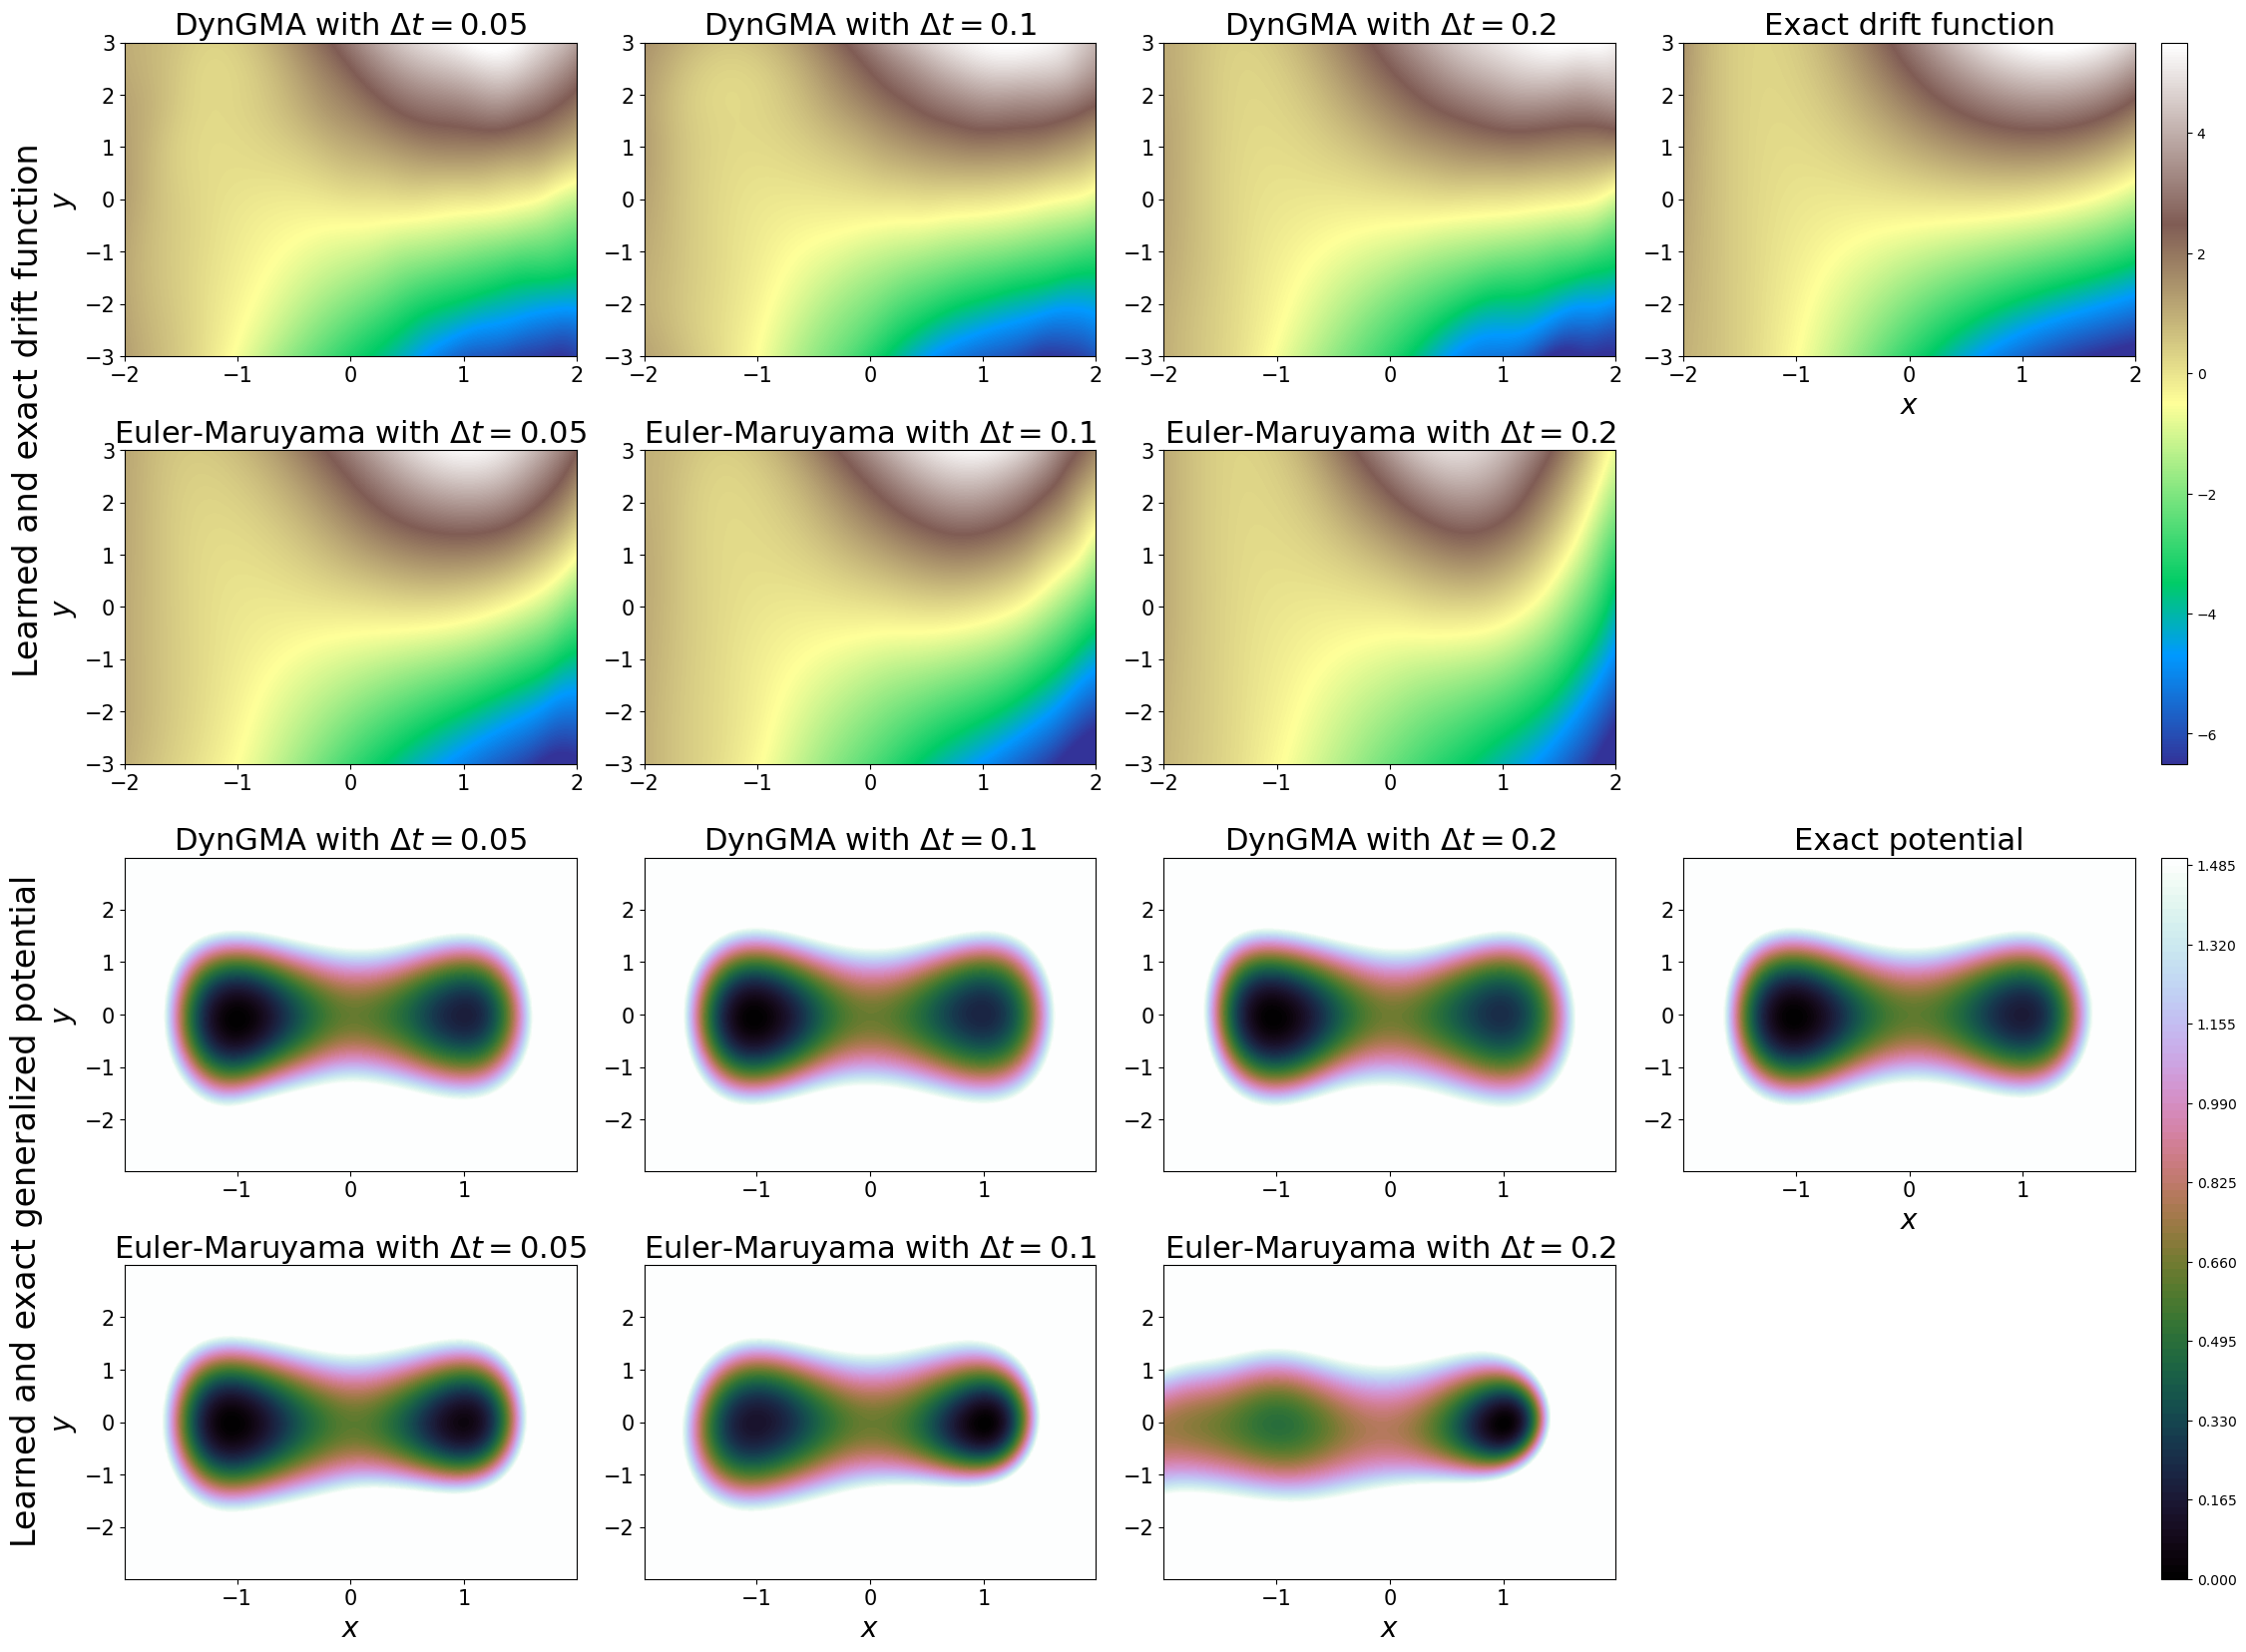

In [5]:
from matplotlib import colors

norm1 = colors.Normalize(vmin=-6.5, vmax=5.5)
norm2 = colors.Normalize(vmin=0, vmax=1.5)

fig = plt.figure(figsize=(26, 20))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
    wspace=0.15, hspace=0.3)

gs = gridspec.GridSpec(nrows=4, ncols=4, height_ratios=[1, 1, 1,1])
print('sss')
####################  plot vf
cmap='gist_earth'
cmap='terrain'
axf = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2]), fig.add_subplot(gs[0,3]),
       fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])] 

c2 = axf[3].pcolormesh(X, Y, exactf, cmap=cmap, norm=norm1)
axf[3].set_title('Exact drift function', fontsize=22)

for i, h in enumerate(['0.05','0.1','0.2']):
    local = 'outputs/h=' + h + 'seed={}MG'.format(errorMG[h][0].argmin())
    net = torch.load(local + '/model_best.pkl', map_location=torch.device('cpu'))
    learnedf = ((net.to('cpu').vf(x)[...,0]).reshape(Ng, Ng)).detach()
    c2 = axf[i].pcolormesh(X, Y, learnedf, cmap=cmap, norm=norm1)
    axf[i].set_title('DynGMA with $\Delta t =$'+h, fontsize=22)
    
for i, h in enumerate(['0.05','0.1','0.2']):
    local = 'outputs/h=' + h + 'seed={}EM'.format(errorMG[h][0].argmin())
    net = torch.load(local + '/model_best.pkl', map_location=torch.device('cpu'))
    learnedf = ((net.to('cpu').vf(x)[...,0]).reshape(Ng, Ng)).detach()
    c2 = axf[i+4].pcolormesh(X, Y, learnedf, cmap=cmap, norm=norm1)
    axf[i+4].set_title('Euler-Maruyama with $\Delta t =$'+h, fontsize=22)

 
caxf = fig.add_axes([axf[3].get_position().x1+0.01,axf[6].get_position().y0,
                    0.01,axf[3].get_position().height+ axf[3].get_position().y0-axf[6].get_position().y0])     
cb=fig.colorbar(c2, ax=axf, cax= caxf)
xsize=20
for ax in axf:
    ax.tick_params(labelsize=15)
axf[0].set_ylabel(r'$y$', fontsize=xsize)
axf[4].set_ylabel(r'$y$', fontsize=xsize)
axf[3].set_xlabel(r'$x$', fontsize=xsize)
axf[0].text(-3, -9, 'Learned and exact drift function', fontsize=24, rotation='vertical')

################## plot fdm
cmap=plt.get_cmap('cubehelix')
axV = [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1]), fig.add_subplot(gs[2,2]), fig.add_subplot(gs[2,3]),
       fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1]), fig.add_subplot(gs[3,2])] 

c1 = axV[3].contourf(XX, YY, V_FD, levels=100, cmap=cmap, norm=norm2)
axV[3].set_title('Exact potential', fontsize=22)



for i, h in enumerate(['0.05','0.1','0.2']):
    local = 'outputs/h=' + h + 'seed={}MG_PINN'.format(errorMG[h][2].argmin())
    V_NN   = get_V_NN(x_list, local)
    c1 = axV[i].contourf(XX, YY, V_NN, levels=100, cmap=cmap, norm=norm2)
    axV[i].set_title('DynGMA with $\Delta t =$'+h, fontsize=22)

for i, h in enumerate(['0.05','0.1','0.2']):
    local = 'outputs/h=' + h + 'seed={}EM_PINN'.format(errorEM[h][2].argmin())
    V_NN   = get_V_NN(x_list, local)
    c1 = axV[i+4].contourf(XX, YY, V_NN, levels=100, cmap=cmap, norm=norm2)
    axV[i+4].set_title('Euler-Maruyama with $\Delta t =$'+h, fontsize=22)

cax = fig.add_axes([axV[3].get_position().x1+0.01,axV[6].get_position().y0,
                    0.01,axV[3].get_position().height+ axV[3].get_position().y0-axV[6].get_position().y0])     
cb=fig.colorbar(c1, ax=axV, cax= cax)
for ax in axV:
    ax.tick_params(labelsize=15)
axV[0].set_ylabel(r'$y$', fontsize=xsize)
axV[4].set_ylabel(r'$y$', fontsize=xsize)

for ax in axV[3:]:
    ax.set_xlabel(r'$x$', fontsize=xsize)
axV[0].text(-3, -10, 'Learned and exact generalized potential', fontsize=24, rotation='vertical')


In [7]:

fig.savefig('td.png', bbox_inches='tight', dpi=100) 
print('sss')
# fig.savefig('td.pdf', format='pdf', bbox_inches='tight', dpi=50) 
print(errorMG['0.05'].mean(axis=1))
print(errorMG['0.05'].std(axis=1))
print(errorMG['0.05'].argmin(axis=1))


sss
[0.00993872 0.04587117 0.05329851]
[0.00449176 0.00466486 0.01495187]
[3 0 1]
